In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from transformers import pipeline#
#Using Hugging Face Transformers for QA model
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

def get_wikipedia_context(topic):
    url = f"https://en.wikipedia.org/wiki/{topic}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    paragraphs = soup.find_all('p')
    context = ' '.join([para.text for para in paragraphs])
    return context

def generate_qa_pairs(context):
    questions = [
        "What is the main topic discussed?",
        "Who are the key figures mentioned?",
        "What is the historical significance of the topic?",
        "What are the major events related to the topic?",
        "What are the applications or implications of this topic?"
    ]
    
    
    qa_model = pipeline('question-answering', model='distilbert-base-cased-distilled-squad', revision='626af31')
    
    # Generate answers
    answers = [qa_model(question=q, context=context)['answer'] for q in questions]
    
    return questions, answers

topics_df = pd.read_csv('../data/wikipedia_topics.csv')

print(topics_df.columns)

topics = topics_df['Topic'].tolist()  

corpus = []

for topic in topics:
    context = get_wikipedia_context(topic)
    questions, answers = generate_qa_pairs(context)
    corpus.append({
        'context': context,
        'questions': [{'input_text': q} for q in questions],
        'answers': {'input_text': answers, 'answer_start': [], 'answer_end': []}  
    })

new_df = pd.DataFrame(corpus)

# Save the corpus to a CSV file
new_df.to_csv('../data/new_corpus.csv', index=False)


Index(['Topic'], dtype='object')


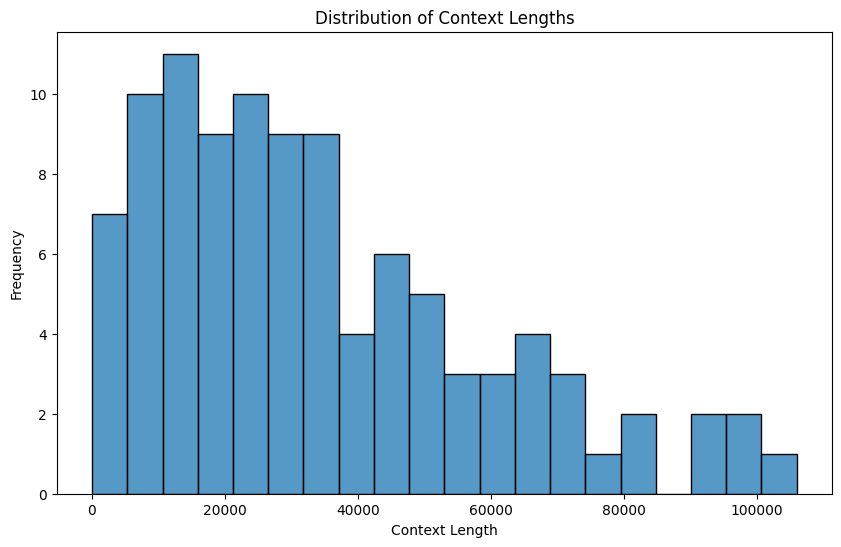

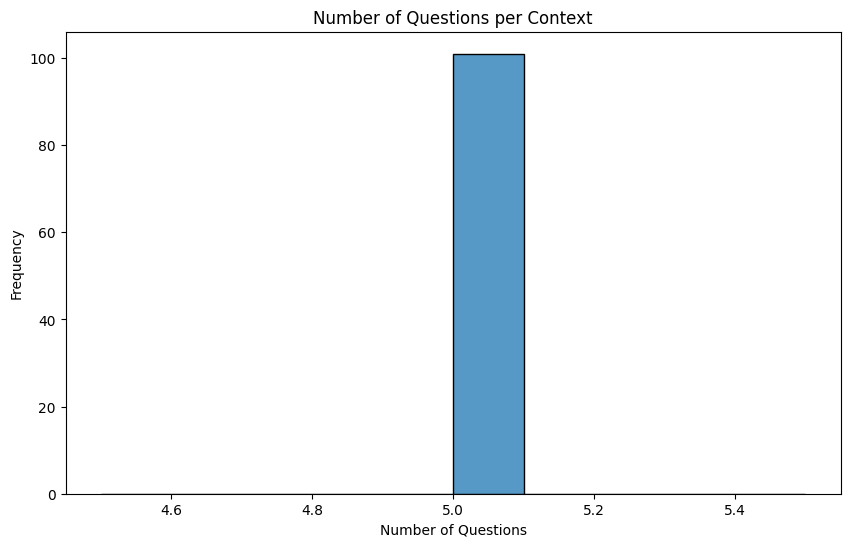

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
new_df = pd.read_csv('../data/new_corpus.csv')


new_df['questions'] = new_df['questions'].apply(lambda x: eval(x))
new_df['answers'] = new_df['answers'].apply(lambda x: eval(x))


context_lengths = new_df['context'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(context_lengths, bins=20)
plt.title('Distribution of Context Lengths')
plt.xlabel('Context Length')
plt.ylabel('Frequency')
plt.show()


num_questions = new_df['questions'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(num_questions, bins=10)
plt.title('Number of Questions per Context')
plt.xlabel('Number of Questions')
plt.ylabel('Frequency')
plt.show()
